# Було проведено дослідження 2 маркетингових кампаній при сталому бюджеті на рекламу. На основі даних 2 датасетів про A/B тестування, розрахувати основні маркетингові показники та виявити, яка зміна була ефективнішою та принесла більшу прибутковість:
### CTR = кліки на сайті/покази * 100%
### CPC = витрати / кліки на сайті
### CPM = витрати / покази * 1000
### CPA = витрати / кількість покупок
### CR = кількість покупок / кліки на сайті * 100%

## Ціль маркетингової програми - збільшення показника CTR
## Результати подати в текстовому та графічних виглядах. Сформулювати грунтовні висновки

#### Імпортуємо необхідні бібліотеки

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta, datetime
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind

#### Зчитуємо дані

In [24]:
control_df = pd.read_csv('data/control_group.csv', sep =";")
control_df.head()


,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Control Campaign,1.08.2019,2280,82702.0,56930.0,7016.0,2290.0,2159.0,1819.0,618.0
1,Control Campaign,2.08.2019,1757,121040.0,102513.0,8110.0,2033.0,1841.0,1219.0,511.0
2,Control Campaign,3.08.2019,2343,131711.0,110862.0,6508.0,1737.0,1549.0,1134.0,372.0
3,Control Campaign,4.08.2019,1940,72878.0,61235.0,3065.0,1042.0,982.0,1183.0,340.0
4,Control Campaign,5.08.2019,1835,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
test_df = pd.read_csv('data/test_group.csv', sep =";")
test_df.head()

,Campaign Name,Date,Spend [USD],# of Impressions,Reach,# of Website Clicks,# of Searches,# of View Content,# of Add to Cart,# of Purchase
0,Test Campaign,1.08.2019,3008,39550,35820,3038,1946,1069,894,255
1,Test Campaign,2.08.2019,2542,100719,91236,4657,2359,1548,879,677
2,Test Campaign,3.08.2019,2365,70263,45198,7885,2572,2367,1268,578
3,Test Campaign,4.08.2019,2710,78451,25937,4216,2216,1437,566,340
4,Test Campaign,5.08.2019,2297,114295,95138,5863,2106,858,956,768


## Підготовка даних

In [35]:
column_names = ['Campaign Name', 'Date', 'Amount Spent', 'Impressions', 
                'Unique Impressions', 'Clicks', 'Number of Searches', 
                'Page Views', 'Add to Carts', 'Purchases']
control_df.columns = column_names

control_df.isnull().sum()

Campaign Name         0
Date                  0
Amount Spent          0
Impressions           1
Unique Impressions    1
Clicks                1
Number of Searches    1
Page Views            1
Add to Carts          1
Purchases             1
dtype: int64

In [37]:
test_df.columns = column_names

test_df.isnull().sum()

Campaign Name         0
Date                  0
Amount Spent          0
Impressions           0
Unique Impressions    0
Clicks                0
Number of Searches    0
Page Views            0
Add to Carts          0
Purchases             0
dtype: int64

### Можна помітити що в датасеті контрольної групи містяться пропуски. Усунемо їх

In [39]:
control_df.iloc[:, 3:] = control_df.iloc[:, 3:].fillna(control_df.iloc[:, 3:].median())

for column in control_df.columns[3:]:
    control_df[column] = control_df[column].round().astype('int64')

control_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Campaign Name       30 non-null     object
 1   Date                30 non-null     object
 2   Amount Spent        30 non-null     int64 
 3   Impressions         30 non-null     int64 
 4   Unique Impressions  30 non-null     int64 
 5   Clicks              30 non-null     int64 
 6   Number of Searches  30 non-null     int64 
 7   Page Views          30 non-null     int64 
 8   Add to Carts        30 non-null     int64 
 9   Purchases           30 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 2.5+ KB


### Для зручності об'єднаємо в один датафрейм

In [42]:
ab_data = pd.concat([control_df, test_df])

ab_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 0 to 29
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Campaign Name       60 non-null     object
 1   Date                60 non-null     object
 2   Amount Spent        60 non-null     int64 
 3   Impressions         60 non-null     int64 
 4   Unique Impressions  60 non-null     int64 
 5   Clicks              60 non-null     int64 
 6   Number of Searches  60 non-null     int64 
 7   Page Views          60 non-null     int64 
 8   Add to Carts        60 non-null     int64 
 9   Purchases           60 non-null     int64 
dtypes: int64(8), object(2)
memory usage: 5.2+ KB


### Переходимо до розрахунку маркетингових показників


In [44]:

ab_data['CTR'] = ab_data['Clicks'] / ab_data['Impressions']
ab_data['CPC'] = ab_data['Amount Spent'] / ab_data['Clicks']
ab_data['CPM'] = ab_data['Amount Spent'] / ab_data['Page Views']
ab_data['CPA'] = ab_data['Amount Spent'] / ab_data['Purchases']
ab_data['CR'] = ab_data['Purchases'] / ab_data['Clicks']

ab_data.head()

,Campaign Name,Date,Amount Spent,Impressions,Unique Impressions,Clicks,Number of Searches,Page Views,Add to Carts,Purchases,CTR,CPC,CPM,CPA,CR
0,Control Campaign,1.08.2019,2280,82702,56930,7016,2290,2159,1819,618,0.084835,0.324971,1.056044,3.689320,0.088084
1,Control Campaign,2.08.2019,1757,121040,102513,8110,2033,1841,1219,511,0.067003,0.216646,0.954373,3.438356,0.063009
2,Control Campaign,3.08.2019,2343,131711,110862,6508,1737,1549,1134,372,0.049411,0.360018,1.512589,6.298387,0.057160
3,Control Campaign,4.08.2019,1940,72878,61235,3065,1042,982,1183,340,0.042057,0.632953,1.975560,5.705882,0.110930
4,Control Campaign,5.08.2019,1835,113430,91579,5224,2390,1984,1339,501,0.046055,0.351263,0.924899,3.662675,0.095904


In [45]:
metrics = ["CTR","CPC","CPM","CPA","CR"]

average_metrics = ab_data.groupby('Campaign Name')[metrics].mean().reset_index()
average_metrics

,Campaign Name,CTR,CPC,CPM,CPA,CR
0,Control Campaign,0.050795,0.490120,1.379142,5.006017,0.114143
1,Test Campaign,0.102423,0.468718,1.543885,5.899589,0.092312


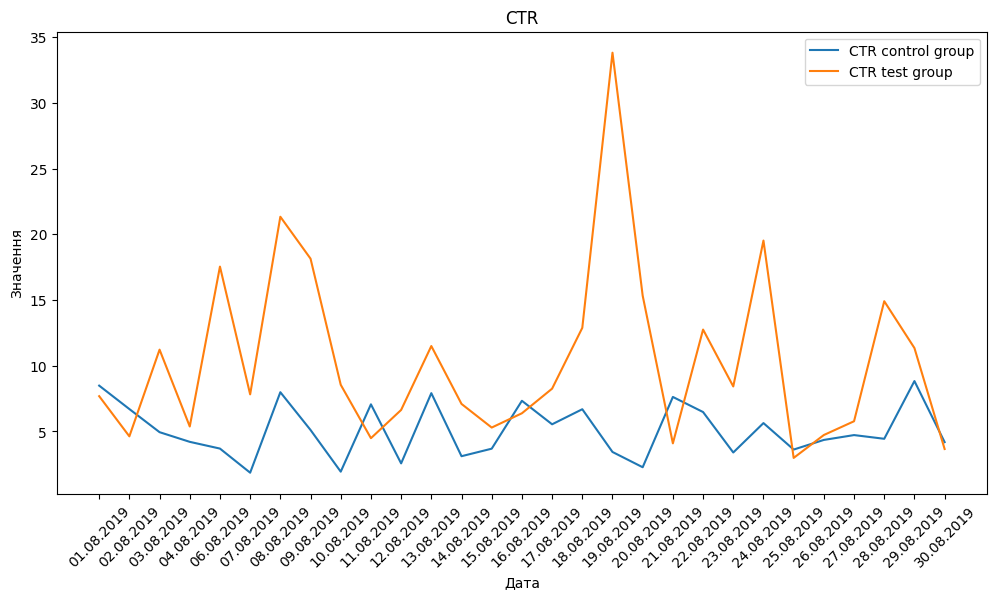

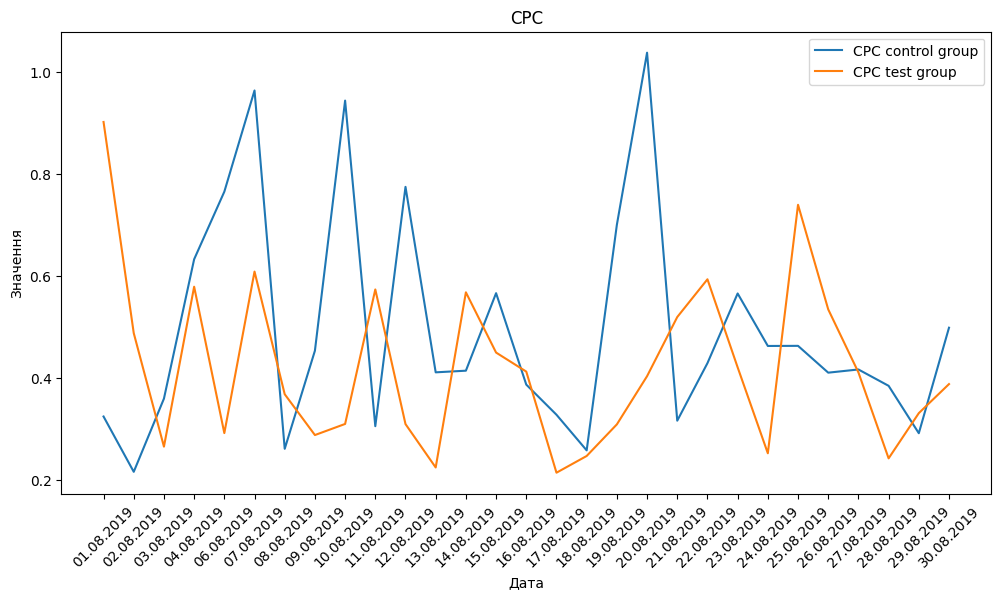

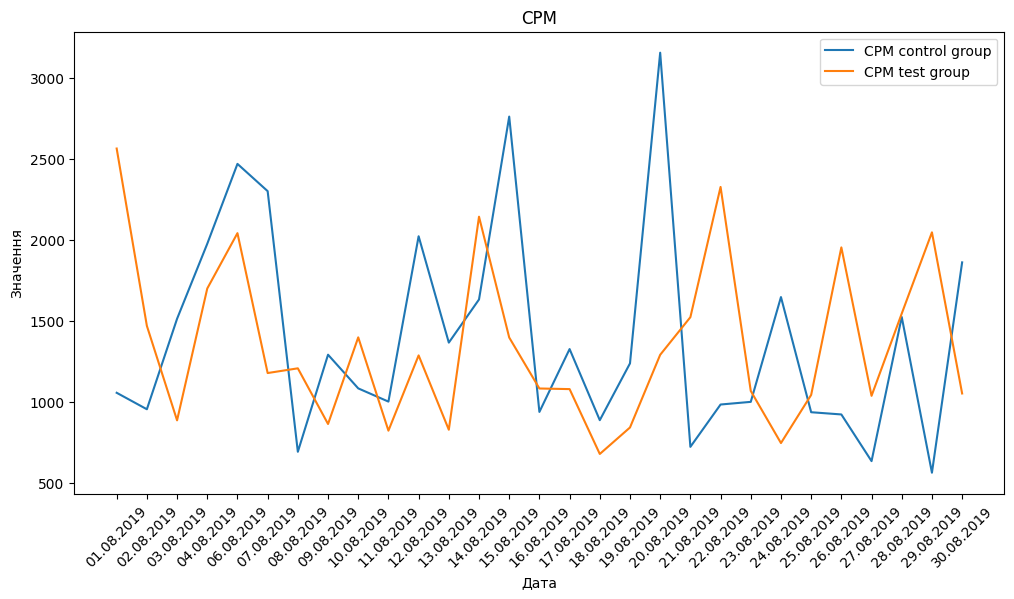

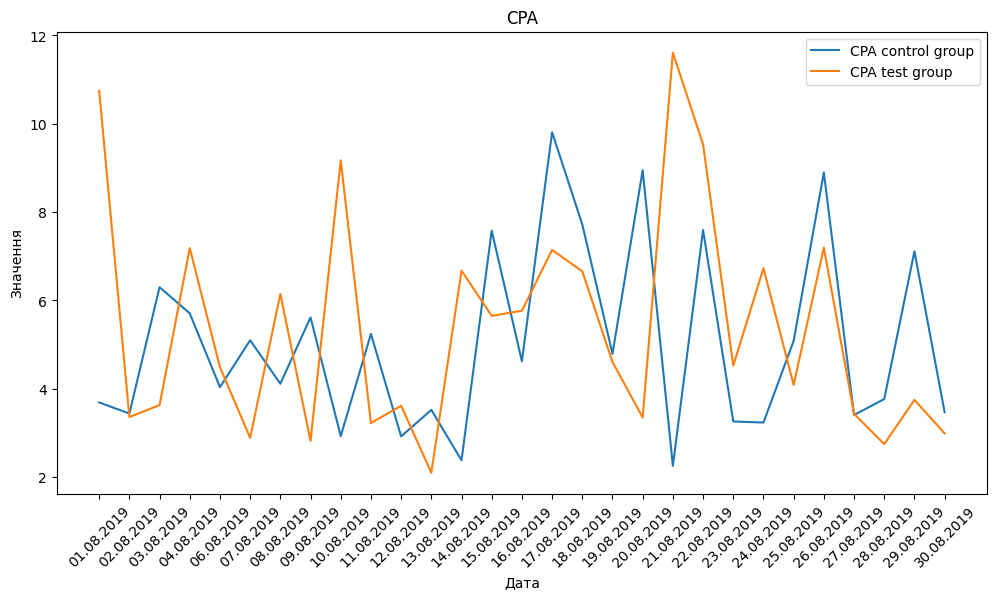

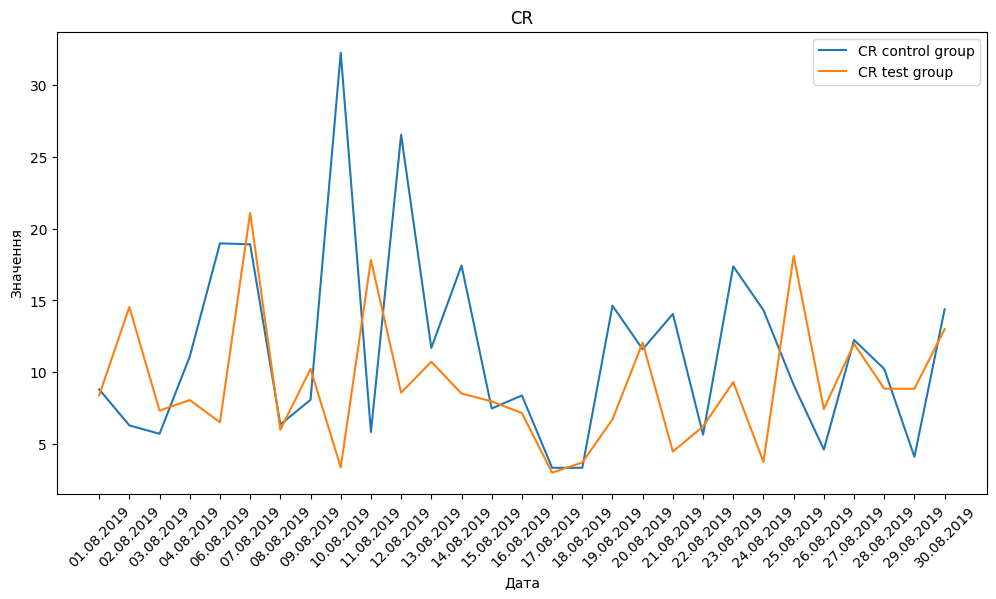

In [48]:
indcitaros_array=["CTR","CPC","CPM","CPA","CR"]
for indicate in indcitaros_array:

    x = data_control_group['Date']
    y1 = data_control_group[indicate]
    y2 = data_test_group[indicate]
    
    plt.figure(figsize=(12, 6)) 
    plt.plot(x, y1, label=f'{indicate} control group')
    plt.plot(x, y2, label=f'{indicate} test group')
    
    plt.xlabel('Дата')
    plt.ylabel('Значення')
    plt.title(indicate)
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

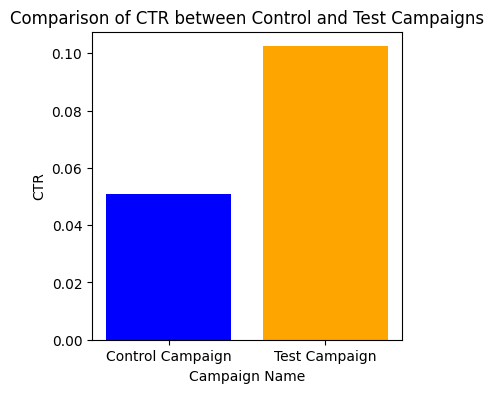

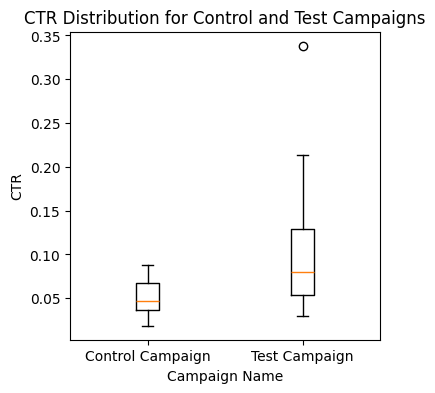

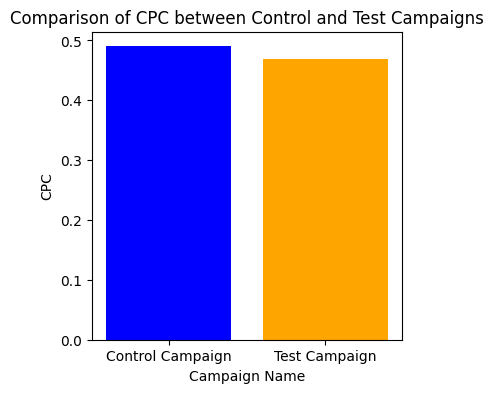

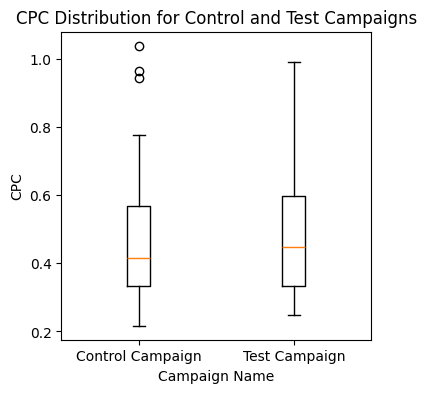

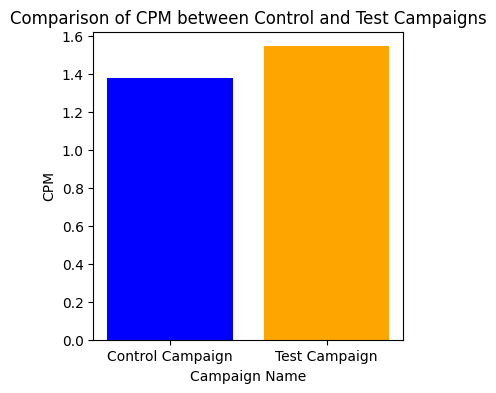

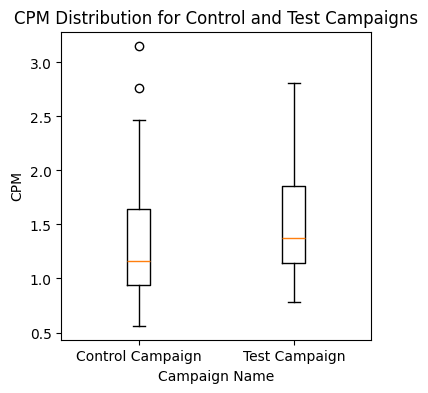

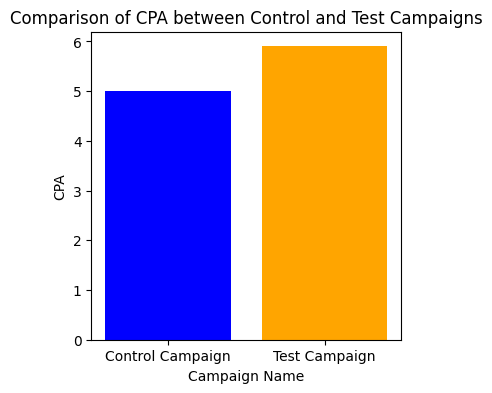

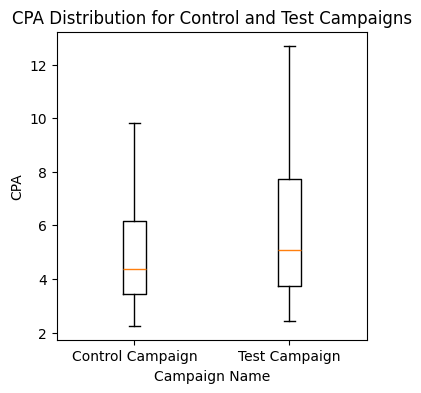

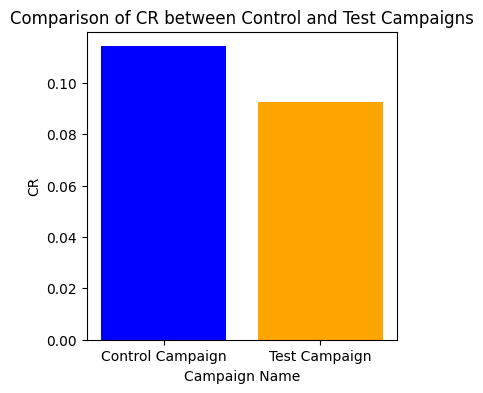

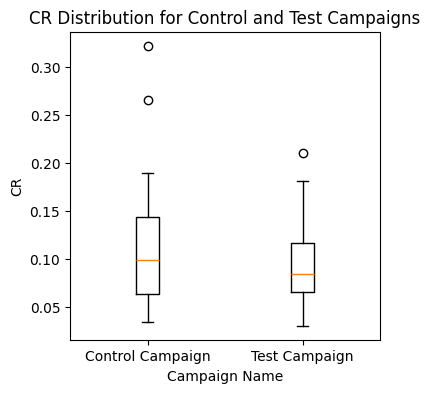

In [75]:
indcitaros_array=["CTR","CPC","CPM","CPA","CR"]

metrics = ['CTR', 'CPC', 'CPM', 'CPA', 'CR']

# Побудова бар-плотів для кожного показника
for metric in metrics:
    plt.figure(figsize=(4, 4))
    plt.bar(average_metrics['Campaign Name'], average_metrics[metric], color=['blue','orange'])
    plt.xlabel('Campaign Name')
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric} between Control and Test Campaigns')

    plt.figure(figsize=(4, 4))
    plt.boxplot([ab_data.loc[ab_data['Campaign Name'] == 'Control Campaign', metric],
                 ab_data.loc[ab_data['Campaign Name'] == 'Test Campaign', metric]],tick_labels=['Control Campaign', 'Test Campaign'])
    plt.xlabel('Campaign Name')
    plt.ylabel(metric)
    plt.title(f'{metric} Distribution for Control and Test Campaigns')
    plt.show()




       Campaign Name        Date  Amount Spent  Impressions  \
0   Control Campaign   1.08.2019          2280        82702   
1   Control Campaign   2.08.2019          1757       121040   
2   Control Campaign   3.08.2019          2343       131711   
3   Control Campaign   4.08.2019          1940        72878   
4   Control Campaign   5.08.2019          1835       113430   
5   Control Campaign   6.08.2019          3083       109076   
6   Control Campaign   7.08.2019          2544       142123   
7   Control Campaign   8.08.2019          1900        90939   
8   Control Campaign   9.08.2019          2813       121332   
9   Control Campaign  10.08.2019          2149       117624   
10  Control Campaign  11.08.2019          2490       115247   
11  Control Campaign  12.08.2019          2319       116639   
12  Control Campaign  13.08.2019          2697        82847   
13  Control Campaign  14.08.2019          1875       145248   
14  Control Campaign  15.08.2019          2774       13

## Проведемо безпосередньо A/B тестування ти визначення результатів значущості. Оскільки бюджет для контрольної групи та тестової групи майже незмінний - припускаємо що у випадку відмінностях показників груп, фактором впливу є зміни при тестуванні.


In [96]:
indicators=ab_data.columns[2:]
data_control_group=ab_data[ab_data["Campaign Name"]=="Control Campaign"]
data_test_group=ab_data[ab_data["Campaign Name"]=="Test Campaign"]
for indicator in indicators:
    if shapiro(data_test_group[indicator]).pvalue < 0.05:
        print(f'Ряд {indicator} групи {data_test_group["Campaign Name"].iloc[0]} не є нормально розподіленим. Середнє значення {data_test_group[indicator].mean()}')
    else:
        print(f'Ряд {indicator} групи {data_test_group["Campaign Name"].iloc[0]} є нормально розподіленим. Середнє значення {data_test_group[indicator].mean()}')
    if shapiro(data_control_group[indicator]).pvalue < 0.05:
        print(f'Ряд {indicator} групи {data_control_group["Campaign Name"].iloc[0]} не є нормально розподіленим. Середнє значення {data_control_group[indicator].mean()}')
    else:
        print(f'Ряд {indicator} групи {data_control_group["Campaign Name"].iloc[0]} є нормально розподіленим. Середнє значення {data_control_group[indicator].mean()}')
    print('')
    if (shapiro(data_test_group[indicator]).pvalue < 0.05) | (shapiro(data_control_group[indicator]).pvalue < 0.05):
        stat, p_value = mannwhitneyu(data_test_group[indicator], data_control_group[indicator])
        print(f'U-статистика: {stat}')
        print(f'P-значення: {p_value}')
        alpha = 0.05
        if p_value < alpha:
            print(f"Відхиляємо нульову гіпотезу:  розподіли по полю {indicator} значущо різні")
            if data_test_group[indicator].mean() > data_control_group[indicator].mean():
                print('Тестова група показала вищі результати')
            else:
                print('Контрольна група показала вищі результати')
        else:
            print(f"Не відхиляємо нульову гіпотезу: розподіли по полю {indicator} не значущо різні")
    else:
        stat, p_value = ttest_ind(data_test_group[indicator], data_control_group[indicator])
        print(f'T-статистика: {stat}')
        print(f'P-значення: {p_value}')
        alpha = 0.05
        if p_value < alpha:
            print(f"Відхиляємо нульову гіпотезу: розподіли по полю {indicator} значущо різні")
            if data_test_group[indicator].mean() > data_control_group[indicator].mean():
                print('Тестова група показала вищі результати')
            else:
                print('Контрольна група показала вищі результати')
        else:
            print(f"Не відхиляємо нульову гіпотезу: розподіли по полю {indicator} не значущо різні")
    print('--------------------------------------------------------------------------')
    print('')

Ряд Amount Spent групи Test Campaign є нормально розподіленим. Середнє значення 2563.0666666666666
Ряд Amount Spent групи Control Campaign є нормально розподіленим. Середнє значення 2288.4333333333334

T-статистика: 2.969991516565667
P-значення: 0.004326251207113236
Відхиляємо нульову гіпотезу: розподіли по полю Amount Spent значущо різні
Тестова група показала вищі результати
--------------------------------------------------------------------------

Ряд Impressions групи Test Campaign є нормально розподіленим. Середнє значення 74584.8
Ряд Impressions групи Control Campaign є нормально розподіленим. Середнє значення 109688.76666666666

T-статистика: -4.986991949145323
P-значення: 5.889238456479816e-06
Відхиляємо нульову гіпотезу: розподіли по полю Impressions значущо різні
Контрольна група показала вищі результати
--------------------------------------------------------------------------

Ряд Unique Impressions групи Test Campaign є нормально розподіленим. Середнє значення 53491.56666

# Висновки:
### A/B тестування мало значущий влпив на такі показники: 
#### CTR, тестова група показала вищі результати

## Також A/B тестування спричинило значущу зміну таких параметрів:
#### Amount Spent, Тестова група показала вищі результати
#### Impressions , Контрольна група показала вищі результати
#### Unique Impressions , Контрольна група показала вищі результати
#### Add to Carts , Контрольна група показала вищі результати

### Середня кількість показів контрольної групи значущо вищі , відповідно через це , CTR тестової групи значущо вищий від контрольної.
## Формуємо висновки про те, що із впровадженням тестової кампанії, цільовий показник CTR значущо більший від показника контрольної групи.